# Neural Style Transfer
##### Author: Prasanna Rahavendra A
##### github: [Prasanna2000](https://github.com/Prasanna2000)

### In this project we'll use transfer learning for the task of neural style transfer.
### We will make use a pre-learned VGG19, trained on the ImageNet dataset for this task.

## Importing necessary modules

In [18]:
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19

### Loading the VGG 19 Module that we'll use for this project

In [19]:
model = VGG19(include_top=False,weights="imagenet")
model.trainable = False

model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [20]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Helper Functions to Preprocess, Deprocess and Display the Image

In [21]:
def load_and_process_image(img):
    img = load_img(img)
    img = img_to_array(img)
    img = preprocess_input(img)
    img = np.expand_dims(img,axis = 0)
    
    return img

#### We deprocess the image in a certain way in which it was preprocessed for the input of the model (VGG 19)

In [44]:
def deprocess(array):
    '''Does the opposite of preprocess_input method of vgg19'''
    array[:,:,0] += 103.939
    array[:,:,1] += 116.779
    array[:,:,2] += 123.68
    
    array = array[:,:,::-1]
    
    array = np.clip(array,0,255).astype(np.uint8)
    
    return array

In [45]:
def display_image(image):
    if len(image.shape) == 4:
        img = np.squeeze(image,axis = 0)
    img = deprocess(img)
    
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    
    return

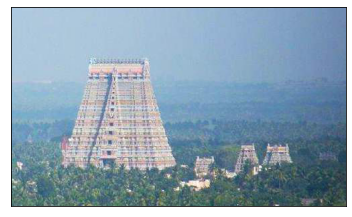

In [46]:
display_image(load_and_process_image("content.jpg"))

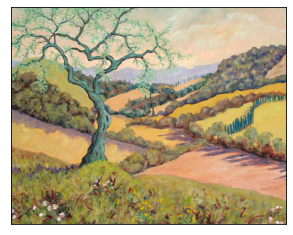

In [47]:
display_image(load_and_process_image("style.jpg"))

## Content and Style Models

In [48]:
content_layer = "block5_conv2"
style_layers = ["block1_conv1","block3_conv1","block5_conv1"]

content_model = Model(
    inputs = model.input,
    outputs = model.get_layer(content_layer).output
)

style_models = [Model(inputs = model.input,
                     outputs = model.get_layer(layer).output) for layer in style_layers]

## Content Cost

In [49]:
def content_cost(content,generated):
    activations_of_content_img = content_model(content)
    activations_of_generated_img = content_model(generated)
    
    cost = tf.reduce_mean(tf.square(activations_of_content_img - activations_of_generated_img))
    
    return cost

## Gram Matrix

#### Gram Matrices are used to calculate the style cost.

In [50]:
def gram_matrix(array):
    num_channels = int(array.shape[-1])
    reshaped_array = tf.reshape(array,[-1,num_channels])
    num_elements = tf.shape(reshaped_array)[0]
    
    gram_matrix = tf.matmul(reshaped_array, reshaped_array, transpose_a = True)
    scaled_gram_matrix = gram_matrix/tf.cast(num_elements,tf.float32)
    
    return scaled_gram_matrix

## Style Cost

In [51]:
def style_cost(style, generated):
    weight = 1/len(style_models)
    total_style_cost = 0
    
    for model in style_models:
        activations_of_style_img = model(style)
        activations_of_generated_img = model(generated)
        
        style_img_gram_matrix = gram_matrix(activations_of_style_img)
        generated_img_gram_matrix = gram_matrix(activations_of_generated_img)
        
        current_cost = tf.reduce_mean(tf.square(style_img_gram_matrix - generated_img_gram_matrix))
        total_style_cost += current_cost * weight
        
    return total_style_cost
        

## Training Loop

In [52]:
import time
generated_images = []

def training(content_path, style_path, epochs = 20, alpha = 10., beta = 20.):
    content_img = load_and_process_image(content_path)
    style_img = load_and_process_image(style_path)
    
    generated_image = tf.Variable(content_img, dtype = tf.float32)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate = 7.0)
    
    best_cost = 1e12 + 0.1 #some high value
    best_img = None
    
    start_time = time.time()
    
    print(f"Starting Training...")
    
    for i in range(epochs):
        with tf.GradientTape() as tape:
            cont_cost = content_cost(content_img,generated_image)
            styl_cost = style_cost(style_img,generated_image)
            
            total_cost = alpha * cont_cost + beta * styl_cost
            
            grads = tape.gradient(total_cost, generated_image)
            optimizer.apply_gradients([(grads,generated_image)])
            
            if total_cost < best_cost:
                best_cost = total_cost
                best_img = generated_image.numpy()
            
            print(f"Epoch({i+1}) Cost: {total_cost}. Time elapsed: {round((time.time() - start_time),2)} seconds")
            
            generated_images.append(generated_image.numpy())
            
    return best_img

In [53]:
generated_images = []
best_image = training("content.jpg","style.jpg")

Starting Training...
Epoch(1) Cost: 1324140416.0. Time elapsed: 0.59 seconds
Epoch(2) Cost: 685556864.0. Time elapsed: 1.12 seconds
Epoch(3) Cost: 643807680.0. Time elapsed: 1.66 seconds
Epoch(4) Cost: 405489504.0. Time elapsed: 2.2 seconds
Epoch(5) Cost: 312450112.0. Time elapsed: 2.73 seconds
Epoch(6) Cost: 260180768.0. Time elapsed: 3.27 seconds
Epoch(7) Cost: 222062304.0. Time elapsed: 3.81 seconds
Epoch(8) Cost: 202962064.0. Time elapsed: 4.35 seconds
Epoch(9) Cost: 174623648.0. Time elapsed: 4.88 seconds
Epoch(10) Cost: 146264912.0. Time elapsed: 5.42 seconds
Epoch(11) Cost: 127320048.0. Time elapsed: 5.96 seconds
Epoch(12) Cost: 110942080.0. Time elapsed: 6.5 seconds
Epoch(13) Cost: 98058120.0. Time elapsed: 7.03 seconds
Epoch(14) Cost: 89677360.0. Time elapsed: 7.58 seconds
Epoch(15) Cost: 80725352.0. Time elapsed: 8.11 seconds
Epoch(16) Cost: 71576480.0. Time elapsed: 8.65 seconds
Epoch(17) Cost: 64703780.0. Time elapsed: 9.19 seconds
Epoch(18) Cost: 59039036.0. Time elapsed: 

## Displaying the best image (i.e. the one that had the lease loss)

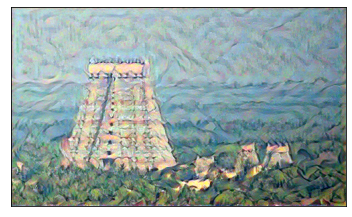

In [54]:
display_image(best_image)

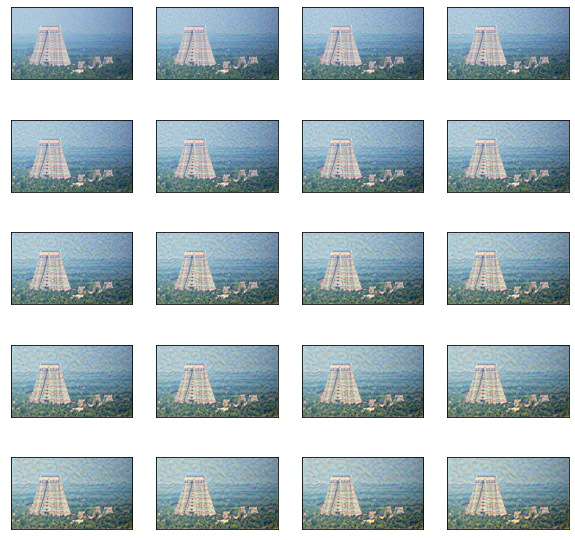

In [55]:
plt.figure(figsize=(10,10))

for i in range(20):
    plt.subplot(5, 4, i+1)
    display_image(generated_images[i])
    
plt.show()